# SegResNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NachoGV/semantic-Segmentation-of-Brain-Metastases-in-MRI-Scans/blob/main/models/SegResNet.ipynb)

## Environment Set Up

### Requirements

In [1]:
!pip install monai[einops]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux20

### Colab Integration

In [2]:
# Set up Colab Workspace
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

!ln -s /content/drive/MyDrive/TFM/data /content/data
!ln -s /content/drive/MyDrive/TFM/utils /content/utils
!ln -s /content/drive/MyDrive/TFM/outputs /content/outputs

Mounted at /content/drive


### Imports

In [3]:
# System
import os
import time
from math import nan

# Data Load & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monai
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import decollate_batch
from monai.utils import set_determinism
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference

# PyTorch
import torch
from torch.utils.data import SequentialSampler

# Utils
from utils.Models import SEGRESNET
from utils.Transforms import Transforms
from utils.Plots import plot_gt_vs_pred
from utils.Datasets import UCSF_Dataset

### Config

In [4]:
# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Print the device
print(f"Device: {device}")

Running on GPU
Device: cuda


In [5]:
# Seeds
seed = 33
set_determinism(seed=seed) # Monai
np.random.seed(seed) # Numpy
torch.manual_seed(seed) # PyTorch

In [6]:
# Configs
%matplotlib inline
%load_ext cudf.pandas
pd.set_option("display.max_columns", None)

### User Configurations

In [7]:
# Model Configurations
model_name = "SegResNet"
model = SEGRESNET
b_size = 1 # Batch Size
t_size = None # Training Subjects (None for all)
v_size = None # Validation Subjects (None for all)
spatial_size = (240, 240, 160)

# Training Configuration
init_epoch = 99 # 0 if new training
best_epoch = 96 # Load model if not training from epoch 0 - None if new training
max_epochs = 100
best_metric = -1
best_metric_epoch = -1
if best_epoch is not None:
    best_metric_epoch = best_epoch
    if os.path.exists(f"outputs/{model_name}/{model_name}_metrics.csv"):
       df = pd.read_csv(f"outputs/{model_name}/{model_name}_metrics.csv")
       best_metric = df.loc[df["epoch"] == best_epoch]["metric"].values[0]

## Load Data

In [8]:
# Load Subjects Information
train_df = pd.read_csv('data/TRAIN.csv')
val_df = pd.read_csv('data/VAL.csv')
test_df = pd.read_csv('data/TEST.csv')

train_df.head()

,SubjectID,Sex,CancerType,ScannerType,In-plane voxel size (mm),Matrix size,Prior Craniotomy/Biopsy/Resection,Age,Scanner Strength (Tesla),Slice Thickness (mm),NumberMetastases,VolumeMetastases_mm3,S-NM,S-V,S-VMax,S-VMin,S-VMean,S-VStd,S-VDiff,T1pre,FLAIR,T1post,T2Synth,Seg,BraTS-seg
0,100381A,Male,Lung,GE 1.5 T Signa HDxt,0.86x0.86,256x256x126,No,71.0,1.5,1.5,4.0,3082.045582,4.0,3082.045541,2445.030377,77.549672,770.511385,974.806455,4.146686e-05,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...
1,100414B,Female,Breast,GE 1.5 T Signa HDxt,0.59x0.59,512x512x50,No,52.0,1.5,3.0,5.0,84.446590,5.0,84.446586,22.656401,11.328201,16.889317,3.940386,3.629621e-06,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...
2,100132B,Male,Lung,GE 1.5 T Signa HDxt,0.5x0.5,512x512x156,No,55.0,1.5,1.2,5.0,734.400029,5.0,734.400029,236.700009,81.300003,146.880006,64.989060,1.136868e-13,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...
3,100212A,Female,Lung,GE 1.5 T Signa HDxt,1.17x1.17,256x256x98,No,52.0,1.5,1.5,9.0,208.062478,9.0,208.062474,43.260514,16.480196,23.118053,7.876000,3.481233e-06,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...
4,100243B,Female,Breast,GE 1.5 T Signa HDxt,0.86x0.86,256x256x100,No,55.0,1.5,1.5,6.0,517.367105,6.0,517.367098,173.932836,8.862820,86.227850,52.711028,6.960829e-06,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...


In [9]:
transforms = Transforms(seed)

# Train Dataset
train_images = [train_df['T1pre'], train_df['FLAIR'], train_df['T1post'], train_df['T2Synth']]
train_labels = train_df['BraTS-seg']
train_dataset = UCSF_Dataset(train_images, train_labels, transforms.train(spatial_size=spatial_size), t_size)

# Validation Dataset
val_images = [val_df['T1pre'], val_df['FLAIR'], val_df['T1post'], val_df['T2Synth']]
val_labels = val_df['BraTS-seg']
val_dataset = UCSF_Dataset(val_images, val_labels, transforms.val(), v_size)

# Samplers
train_sampler = SequentialSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=False, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, sampler=val_sampler)

## Training

### Parameters

In [10]:
# Training
VAL_AMP = True
lr = 1e-4
weight_decay = 1e-5

# Report Frequency
plt_imgs = []
val_interval = 1
plot_interval = 1
best_metric_update = False
best_metric_update_epoch = best_epoch if best_epoch is not None else -1
max_step = len(train_dataset) // train_loader.batch_size - 1
max_val_step = len(val_dataset) // val_loader.batch_size - 3

# Metrics Storages
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
val_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

### Model, Loss, Optimizer & Inference

In [11]:
# Model
model.to(device)

# Load model from file
if init_epoch is not None:
    if os.path.exists(f"outputs/{model_name}/last_{model_name}_{init_epoch}.pth"):
        model.load_state_dict(torch.load(f"outputs/{model_name}/last_{model_name}_{init_epoch}.pth"))

# Report File Headers
if init_epoch is None:
    with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
      f.write(f"epoch,metric,metric_tc,metric_wt,metric_et,train_loss,val_loss\n")

# Loss Function
loss_function = DiceLoss(smooth_nr=1e-5, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

# Inference Method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=spatial_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# AMP to accelerate training
scaler = torch.cuda.amp.GradScaler()

# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

### Training Process

----------
epoch 100/100
TRAIN
   Batch 1/248, train_loss: 0.0742, step time: 8.2734
   Batch 2/248, train_loss: 0.5615, step time: 1.3363
   Batch 3/248, train_loss: 0.2939, step time: 1.3431
   Batch 4/248, train_loss: 0.8426, step time: 1.3409
   Batch 5/248, train_loss: 0.1798, step time: 1.3541
   Batch 6/248, train_loss: 0.4534, step time: 1.3763
   Batch 7/248, train_loss: 0.0583, step time: 1.3602
   Batch 8/248, train_loss: 0.5814, step time: 1.3624
   Batch 9/248, train_loss: 0.0344, step time: 1.3476
   Batch 10/248, train_loss: 0.2466, step time: 1.3782
   Batch 11/248, train_loss: 0.1619, step time: 1.3800
   Batch 12/248, train_loss: 0.2986, step time: 1.3764
   Batch 13/248, train_loss: 0.2925, step time: 1.3834
   Batch 14/248, train_loss: 0.0666, step time: 1.3597
   Batch 15/248, train_loss: 0.2919, step time: 1.3856
   Batch 16/248, train_loss: 0.1477, step time: 1.3872
   Batch 17/248, train_loss: 0.2335, step time: 1.3976
   Batch 18/248, train_loss: 0.2914, step t

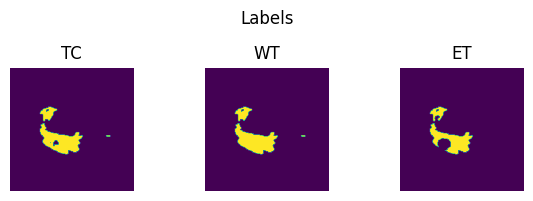

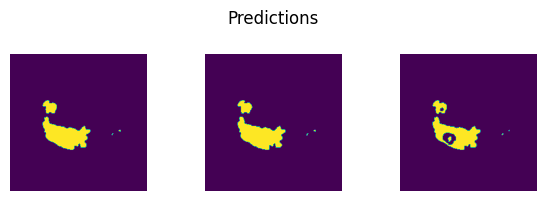

VAL
   Batch 1/31, val_loss: 0.8264
   Batch 2/31, val_loss: 0.9875
   Batch 3/31, val_loss: 0.9561
   Batch 4/31, val_loss: 0.9378
   Batch 5/31, val_loss: 0.9911
   Batch 6/31, val_loss: 0.6797
   Batch 7/31, val_loss: 0.8175
   Batch 8/31, val_loss: 0.9202
   Batch 9/31, val_loss: 0.6860
   Batch 10/31, val_loss: 0.9061
   Batch 11/31, val_loss: 0.8143
   Batch 12/31, val_loss: 0.9653
   Batch 13/31, val_loss: 0.9931
   Batch 14/31, val_loss: 0.9277
   Batch 15/31, val_loss: 0.9831
   Batch 16/31, val_loss: 0.9700
   Batch 17/31, val_loss: 0.9593
   Batch 18/31, val_loss: 0.9260
   Batch 19/31, val_loss: 0.7284
   Batch 20/31, val_loss: 0.8411
   Batch 21/31, val_loss: 0.8611
   Batch 22/31, val_loss: 0.9569
   Batch 23/31, val_loss: 0.9655
   Batch 24/31, val_loss: 0.7298
   Batch 25/31, val_loss: 0.7968
   Batch 26/31, val_loss: 0.9218
   Batch 27/31, val_loss: 0.9717
   Batch 28/31, val_loss: 0.7399
   Batch 29/31, val_loss: 0.9820
   Batch 30/31, val_loss: 0.9577
   Batch 31/31,

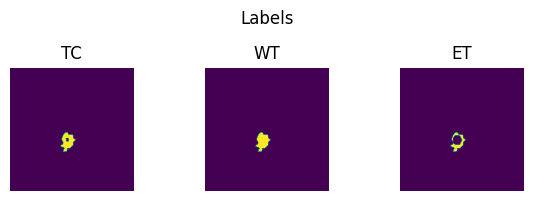

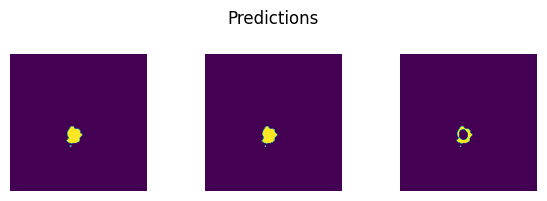

epoch 100
   average train loss: 0.2321
   average validation loss: 0.8926
   saved as best model: False
   current mean dice: 0.6073
   current TC dice: 0.6351
   current WT dice: 0.6411
   current ET dice: 0.5863
Best Mean Metric: 0.6490
time consuming of epoch 100 is: 2307.2172


In [12]:
total_start = time.time()
for epoch in range(init_epoch, max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # TRAINING
    model.train()
    epoch_loss = 0
    step = 0
    print('TRAIN')
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

        # Batch Information
        print(f"   Batch {step}/{len(train_dataset) // train_loader.batch_size}"
              f", train_loss: {loss.item():.4f}"
              f", step time: {(time.time() - step_start):.4f}")

        # Store the image to plot
        if step == max_step:
          plt_imgs = [labels[0], transforms.post()(outputs[0])]

    # Epoch Training Loss
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Plot the Img
    if (epoch + 1) % plot_interval == 0:
      plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], True)

    # VALIDATION
    print('VAL')
    val_loss = 0
    val_step = 0
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            best_val_dice = -1
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_step += 1
                val_outputs = inference(val_inputs)
                loss_value = loss_function(val_outputs[0], val_labels[0])
                val_loss += loss_value.item()

                val_outputs = [transforms.post()(x) for x in val_outputs]

                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

                # Batch Information
                print(f"   Batch {val_step}/{len(val_dataset) // val_loader.batch_size}"
                      f", val_loss: {loss_value.item():.4f}")

                # Store plot image
                if val_step == max_val_step:
                  plt_imgs = [val_labels[0], val_outputs[0]]

            # Epoch Validation Loss
            val_loss /= val_step
            val_loss_values.append(val_loss)

            # Plot the img
            if (epoch + 1) % plot_interval == 0:
              plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], False)

            # Metric Calculation
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            # Save Last State
            torch.save(
                    model.state_dict(),
                    os.path.join(f"outputs/{model_name}/last_{model_name}_{epoch+1}.pth"),
            )

            # Remove previous state
            if epoch > 0:
                os.remove(
                      os.path.join(f"outputs/{model_name}/last_{model_name}_{epoch}.pth")
                )

            # Update Best Metric
            if metric > best_metric:
                # Save best state
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                # Save best model
                torch.save(
                    model.state_dict(),
                    os.path.join(f"outputs/{model_name}/best_{model_name}_{epoch+1}.pth"),
                )
                # Remove previous best model
                if best_metric_update_epoch != -1:
                    os.remove(
                        os.path.join(f"outputs/{model_name}/best_{model_name}_{best_metric_update_epoch}.pth")
                    )
                # Update best epoch
                best_metric_update_epoch = epoch + 1
                best_metric_update = True

            # Save all metrics in csv
            with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
                f.write(f"{epoch + 1},{metric},{metric_tc},{metric_wt},{metric_et},{epoch_loss},{val_loss}\n")

    # REPORT
    print(f"epoch {epoch + 1}\n"
          f"   average train loss: {epoch_loss:.4f}\n"
          f"   average validation loss: {val_loss:.4f}\n"
          f"   saved as best model: {best_metric_update}\n"
          f"   current mean dice: {metric_values[-1]:.4f}\n"
          f"   current TC dice: {metric_values_tc[-1]:.4f}\n"
          f"   current WT dice: {metric_values_wt[-1]:.4f}\n"
          f"   current ET dice: {metric_values_et[-1]:.4f}")
    print(f"Best Mean Metric: {best_metric:.4f}")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    best_metric_update = False

    # When epoch ends, clean GPU memory
    torch.cuda.empty_cache()

total_time = time.time() - total_start

In [13]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.6490 at epoch: 96, total time: 2307.2873425483704.
